In [1]:
%matplotlib
import math
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
import os
import scipy
import IPython.display as ipd

plt.rc('axes', axisbelow=True)
plt.rc('figure', figsize=(9.8, 8))

Using matplotlib backend: <object object at 0x7fc378242460>


In [2]:
# pick some randome music:
# (file, start, end, duration)
#(fn,xs,xe,dur) = ('~/Music/1.wav', 0.5, 10.0, 30.0)
(fn,xs,xe,dur) = ('~/Musik/1.wav', 5.0, 20.0, 30.0)
wave_lr, sr = librosa.load(os.path.expanduser(fn), duration=dur, sr=None, mono=False)

wave_ms = np.array([
    (wave_lr[0] + wave_lr[1]) / 2,
    (wave_lr[0] - wave_lr[1])])

wave = np.array([wave_lr[0], wave_lr[1], wave_ms[0], wave_ms[1]])
awave = np.fabs(wave)

In [3]:
def rolling_rms1(x, n):
    sqr = np.square(x)
    win = np.ones(n)/float(n)
    return np.sqrt(np.convolve(sqr, win, 'valid'))

# about 2 x faster
def rolling_rms2(x, n):
    xc = np.cumsum(np.square(x));
    return np.sqrt((xc[n:] - xc[:-n]) / n)

# 300 ms (default in e.g. dpmeter)
win_size = int(300.0 * sr / 1000.0)
rms = np.array([
    rolling_rms2(wave[0], win_size),
    rolling_rms2(wave[1], win_size),
    rolling_rms2(wave[2], win_size),
    rolling_rms2(wave[3], win_size)])

#print("meassuring: rolling_rms1")
#%time print(rolling_rms1(wave[0], int(win_size)).shape)
#print("meassuring: rolling_rms2")
#%time print(rolling_rms2(wave[0], int(win_size)).shape)

In [4]:
amp_max = (np.amax(awave[0]), np.amax(awave[1]), np.amax(awave[2]), np.amax(awave[3]))
rms_max = (np.amax(rms[0]), np.amax(rms[1]), np.amax(rms[2]), np.amax(rms[3]))

def rolling_amp(x, n):
    return

# 400 ms (default in e.g. ITU-R BS.1770-4)
win_size = 400.0 * sr / 1000.0

# TODO: do we need to weight the input for tp measurement?
tp_max = amp_max
oversampling_fc = 1 / (sr / 192000);
if oversampling_fc > 1:
    print('oversampling by ', oversampling_fc, '\n')
    new_len = int(oversampling_fc) * len(wave[0]) 
    over =  np.array([
        scipy.signal.resample(wave[0], new_len),
        scipy.signal.resample(wave[1], new_len),
        scipy.signal.resample(wave[2], new_len),
        scipy.signal.resample(wave[3], new_len)])
    #print('over: ', over.shape)
    aover = np.fabs(over)
    tp_max = (np.amax(aover[0]), np.amax(aover[1]), np.amax(aover[2]), np.amax(aover[3]))

oversampling by  4.35374149659864 



In [5]:
def todB(a):
    return 20 * math.log10(a)

def print_values(l, v):
    print(f'{l:>5}: '
          f'{v[0]:6.4f}, {todB(v[0]):7.3f} db,  '
          f'{v[1]:6.4f}, {todB(v[1]):7.3f} db,  '
          f'{v[2]:6.4f}, {todB(v[2]):7.3f} db,  '
          f'{v[3]:6.4f}, {todB(v[3]):7.3f} db')

print(f'{" ":5}  {"left":<18},  {"right":<18},  {"mid":<18},  {"side":<18}')
print_values('tp', tp_max)
print_values('amp', amp_max)
print_values('rms', rms_max)

       left              ,  right             ,  mid               ,  side              
   tp: 0.9894,  -0.093 db,  0.9923,  -0.067 db,  0.9828,  -0.150 db,  0.6447,  -3.813 db
  amp: 0.9894,  -0.093 db,  0.9921,  -0.069 db,  0.9827,  -0.152 db,  0.6447,  -3.813 db
  rms: 0.3018, -10.406 db,  0.3018, -10.407 db,  0.2924, -10.681 db,  0.1596, -15.941 db


<IPython.core.display.Javascript object>


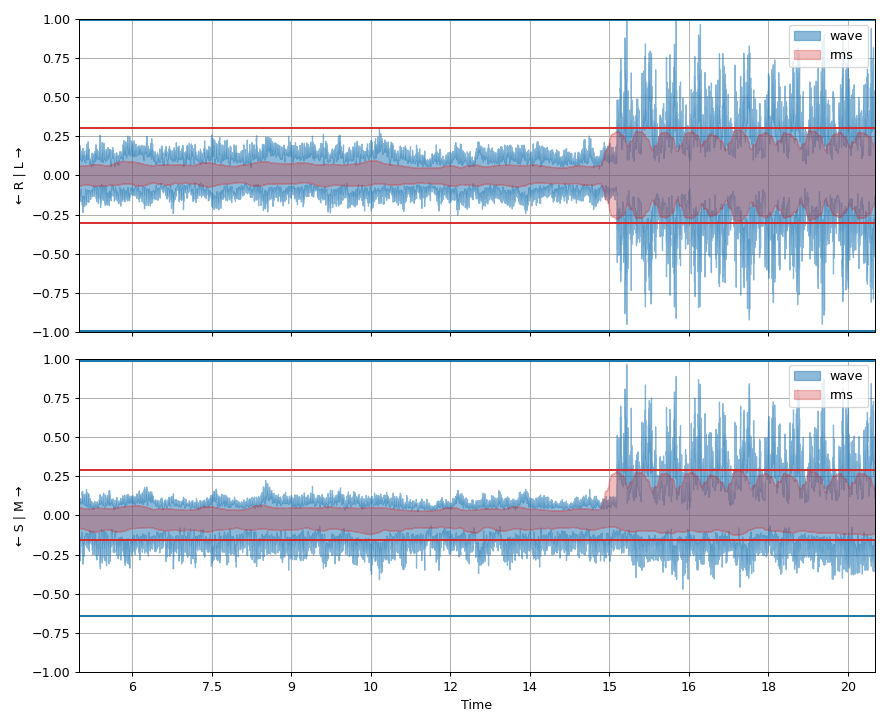

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)

# zooming range in seconds on ax*
# we can do a mono view with ylim=[0.0, 1.0]

# https://librosa.org/doc/main/generated/librosa.display.waveshow.html
# https://matplotlib.org/stable/gallery/color/named_colors.html

ax1.set(xlim=[xs, xe], ylim=[-1.0,1.0])
ax1.grid(True, zorder=0)
librosa.display.waveshow(wave_lr, sr=sr, ax=ax1, label='wave', color='tab:blue', alpha=0.5)
librosa.display.waveshow(rms[:2],  sr=sr, ax=ax1, label='rms', color='tab:red', alpha=0.3)
ax1.axhline(y=tp_max[0], color='tab:green', linestyle='-')
ax1.axhline(y=amp_max[0], color='tab:blue', linestyle='-')
ax1.axhline(y=rms_max[0], color='tab:red', linestyle='-')
ax1.axhline(y=-tp_max[1], color='tab:green', linestyle='-')
ax1.axhline(y=-amp_max[1], color='tab:blue', linestyle='-')
ax1.axhline(y=-rms_max[1], color='tab:red', linestyle='-')
ax1.legend()
ax1.label_outer()
ax1.set_ylabel('← R | L →')

ax2.set(xlim=[xs, xe], ylim=[-1.0,1.0])
ax2.grid(True, zorder=0)

librosa.display.waveshow(wave_ms, sr=sr, ax=ax2, label='wave', color='tab:blue', alpha=0.5)
librosa.display.waveshow(rms[2:],  sr=sr, ax=ax2, label='rms', color='tab:red', alpha=0.3)
ax2.axhline(y=tp_max[2], color='tab:green', linestyle='-')
ax2.axhline(y=amp_max[2], color='tab:blue', linestyle='-')
ax2.axhline(y=rms_max[2], color='tab:red', linestyle='-')
ax2.axhline(y=-tp_max[3], color='tab:green', linestyle='-')
ax2.axhline(y=-amp_max[3], color='tab:blue', linestyle='-')
ax2.axhline(y=-rms_max[3], color='tab:red', linestyle='-')
ax2.legend()
ax2.set_ylabel('← S | M →')

fig.tight_layout()
plt.show()

# looks like we can't limit pan/zoom :/
# https://stackoverflow.com/questions/48709873/restricting-panning-range-in-matplotlib-plots

In [16]:
ipd.Audio(wave, rate=sr)

## TODO
* integrated loudness (lufs)
* short term loudness (lufs)
* short term loudness max (lufs)
* momentary loudness (lufs)
* momentary loudness max (lufs)
* loudness range (lu)
* LR/MS processing

## Notes
* LU Loudness Unit
  * 1 LU == 1dB
* dB = 20 * log10(amplitude)
* amplitude = 10 ^ (dB / 20)
* LUFS = Loudness Units relative to Full Scale

* 'integrated': whole track
* 'momentary': 400ms window updated every 100ms
* 'short-term': sliding 3 sec window

## Links
* https://www.skippyweb.eu/2021/02/from-true-peak-via-rms-to-lufs/
